```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

# Forward Simulation of 2.5D DC Resistivity and Induced Polarization Data on a Tree Mesh

</br>

**Author:** Devin C. Cowan

</br>

**Keywords:** Induced polarization, forward simulation, apparent chargeability, tree mesh.

</br>

**Summary:** Here, we use the modules [SimPEG.electromagnetics.static.resistivity](myst:SimPEG#SimPEG.electromagnetics.static.resistivity) and [SimPEG.electromagnetics.static.induced_polarization](myst:SimPEG#SimPEG.electromagnetics.static.induced_polarization) to simulate 2.5D DC resistivity and induced polarization (IP) data on a tree mesh. This approach is ideal when the local geology doesn't change along the strike direction, as we can leverage the symmetry of the problem to reduce computational cost.

Because the same survey geometry, mesh and topography are used to simulate both DC and IP data, most of the fundamental functionality used in this tutorial is described in detail in the [Forward Simulation of 2.5D DC Resistivity Data on a Tree Mesh](../fwd_dcr_2d.ipynb) tutorial. In this tutorial, we focus primarily on functionality related to the simulation of IP data. More specifically, we discuss:

- Defining the chargeability model
- How to simulate IP data
- Units of the apparent chargeability model and predicted data

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [SimPEG.electromagnetics.static.resistivity](myst:SimPEG#SimPEG.electromagnetics.static.resistivity). All of the functionality specific to IP is imported from [SimPEG.electromagnetics.static.induced_polarization](myst:SimPEG#SimPEG.electromagnetics.static.induced_polarization).
We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). To simulate DC and IP data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static import induced_polarization as ip
from SimPEG.utils import model_builder
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from SimPEG import maps, data
from SimPEG.electromagnetics.static.utils import static_utils

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Simulate 2.5D DC Resistivity Data

When we want to simulate both DC and IP data, we generally start by simulating DC data. Here, we repeat the same steps that were presented in the [Forward Simulation of 2.5D DC Resistivity Data on a Tree Mesh](../fwd_dcr_2d.ipynb) tutorial. Please visit this tutorial for a full description of each step.

### Defining Topography

In [2]:
# Define full 3D topography
x_topo, y_topo = np.meshgrid(
    np.linspace(-3000, 3000, 601), np.linspace(-3000, 3000, 101)
)
z_topo = 40.0 * np.sin(2 * np.pi * x_topo / 800) - 40.0
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

In [3]:
# Interpolate to 2D topography
interp_fun = LinearNDInterpolator(topo_xyz[:, 0:2], topo_xyz[:, -1])
x_topo_2d = np.unique(x_topo)
y_topo_2d = np.zeros_like(x_topo_2d)
z_topo_2d = interp_fun(np.c_[x_topo_2d, y_topo_2d])
topo_2d = np.c_[x_topo_2d, z_topo_2d]

### Defining the DC Survey

Here, the DC survey line is an 800 m long EW dipole-dipole line with an electrode spacing of 40 m. There is a maximum of 10 potential electrodes per current electrode. And the data defined by the receivers are current-normalized voltages in V/A.

In [4]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
dc_data_type = "volt"
end_locations = np.r_[-400.0, 400.0]
station_separation = 40.0
num_rx_per_src = 10

In [5]:
# DC survey line
source_list = static_utils.generate_dcip_sources_line(
    survey_type,
    dc_data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

# Define survey
dc_survey = dc.survey.Survey(source_list)

Text(0.5, 1.0, 'Pseudo-locations')

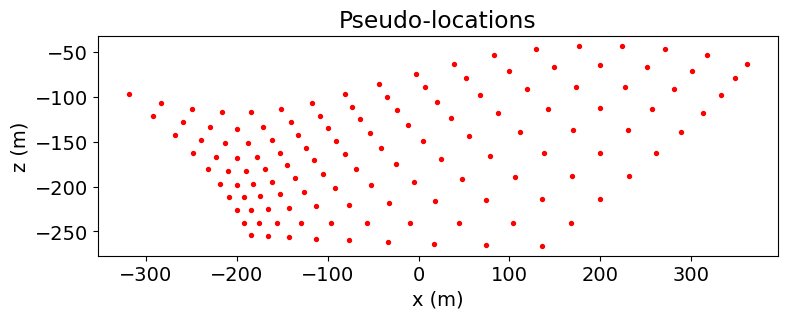

In [6]:
pseudo_locations = static_utils.pseudo_locations(dc_survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations[:, 0], pseudo_locations[:, -1], 8, 'r')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Pseudo-locations')

### Designing a (Tree) Mesh

Here, we generate a tree mesh based on the survey geometry.

In [7]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d, padding_cells_by_level=[0, 0, 4, 4], finalize=False,
)

# Extract unique electrode locations.
unique_locations = dc_survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

### Active Cells

Obtain the indices of the active mesh cells from topography (e.g. cells below surface)

In [8]:
ind_active = active_from_xyz(mesh, topo_2d)
nP = np.sum(ind_active)  # number of parameters

### Conductivity Model and Mapping

Here, the model parameter values (conductivity model) are the electrical conductivities of all subsurface cells (active cells) in units S/m.

In [9]:
# Define electrical conductivities in S/m
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [10]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(nP)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, -160.0], 60.0, mesh.cell_centers[ind_active, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, -100.0], 60.0, mesh.cell_centers[ind_active, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

In [11]:
# Define the mapping from the model to conductivity for all mesh cells.
conductivity_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

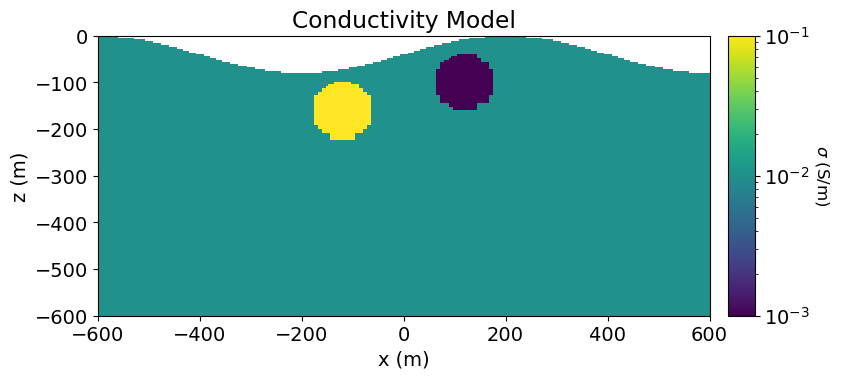

In [12]:
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1, grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.viridis}
)
ax1.set_xlim(-600, 600)
ax1.set_ylim(-600, 0)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

### Projecting to Discretized Topography

Project electrode locations to discretized surface topography.

In [13]:
dc_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

### Defining the DC Simulation

In [14]:
# DC simulation for a conductivity model
dc_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=dc_survey, sigmaMap=conductivity_map
)

### Predicting DC Resistivity Data

In [15]:
dpred_dc = dc_simulation.dpred(conductivity_model)

## Simulate 2.5D IP Data

In order to simulate 2.5D IP data, we will reuse several objects that were generated for the 2.5D DC resistivity simulation. These are:

- the mesh
- the active cells
- the parameters defining the survey geometry

We will also need to generate some new objects. These are:

- an IP survey
- a chargeability model
- a mapping for the chargeability model, and
- an IP simulation

### Defining the IP Survey

Approaches for designing DC and IP surveys were discussed in [Forward Simulation of 2.5D DC Resistivity Data on a Tree Mesh: Designing the Survey](../fwd_dcr_2d.ipynb#Designing-the-Survey). Here, we use the [generate_dcip_sources_line](myst:SimPEG#SimPEG.electromagnetics.static.utils.generate_dcip_sources_line) utility function to generate our IP line. 

In [16]:
ip_data_type = 'apparent_chargeability'

# IP survey line
source_list = static_utils.generate_dcip_sources_line(
    survey_type,
    ip_data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

# Define survey
ip_survey = ip.survey.Survey(source_list)

### Chargeability Model and Mapping

Once again, the model does not need to be synonymous with the physical property values. But it is common to define the model as the chargeabilities for all subsurface (active) cells. So, what are the units?

SimPEG uses a linearized formulation for simulating IP data; see [Simulation2DCellCentered](myst:SimPEG#SimPEG.electromagnetics.static.induced_polarization.Simulation2DCellCentered) or [Simulation2DNodal](myst:SimPEG#SimPEG.electromagnetics.static.induced_polarization.Simulation2DNodal). In this formulation, any standard definition of the chargeability can be used. And the resulting apparent chargeability data will be in terms of the same units; e.g. intrinsic chargeability (V/V or mV/V) or integrated chargeability (ms).

For this tutorial, we use the intrinsic chargeability ($0 \leq \eta \leq 1$) in units V/V. Here, the conductive sphere is chargeable, but the resistive sphere and the host are not.

In [17]:
# Intrinsic chargeability in V/V (unitless).
air_chargeability = 0.0
background_chargeability = 0.0
sphere_chargeability = 1e-1

In [18]:
# Define chargeability model
chargeability_model = background_chargeability * np.ones(nP)

ind_chargeable = model_builder.get_indices_sphere(
    np.r_[-120.0, -160.0], 60.0, mesh.cell_centers[ind_active, :]
)
chargeability_model[ind_chargeable] = sphere_chargeability

In [19]:
# Define mapping for chargeability
chargeability_map = maps.InjectActiveCells(mesh, ind_active, air_chargeability)

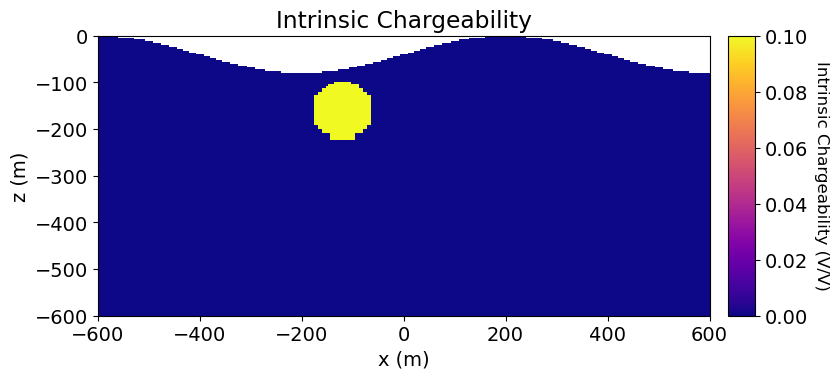

In [20]:
# Plot Chargeability Model
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * chargeability_model,
    ax=ax1,
    grid=False,
    clim=(background_chargeability, sphere_chargeability),
    pcolor_opts={"cmap": mpl.cm.plasma},
)
ax1.set_xlim(-600, 600)
ax1.set_ylim(-600, 0)
ax1.set_title("Intrinsic Chargeability")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
norm = mpl.colors.Normalize(vmin=background_chargeability, vmax=sphere_chargeability)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("Intrinsic Chargeability (V/V)", rotation=270, labelpad=15, size=12)

plt.show()

###  Projecting to Discretized Topography

In [21]:
ip_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

### Defining the IP Forward Simulation

There are two simulation classes which may be used to simulate 2.5D IP data:

- [Simulation2DNodel](myst:SimPEG#SimPEG.electromagnetics.static.induced_polarization.Simulation2DNodal), which defines the discrete electric potentials on mesh nodes.
- [Simulation2DCellCentered](myst:SimPEG#SimPEG.electromagnetics.static.induced_polarization.Simulation2DCellCentered), which defines the discrete electric potentials at cell centers.

For surface DC and IP data, the nodal formulation is more well-suited and will be used here. The cell-centered formulation works well for simulating borehole DC and IP data. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- a background conductivity or resistivity model
- the mapping from the chargeability model to the mesh

If working with electrical conductivity, use the ``sigma`` keyword argument to define the background conductivity on the entire mesh. If working with electrical resistivity, use the ``rho`` keyword argument to define the background resistivity on the entire mesh. The ``etaMap`` is used to define the mapping from the chargeability model to the chargeabilities on the entire mesh.

In [22]:
ip_simulation = ip.Simulation2DNodal(
    mesh,
    survey=ip_survey,
    etaMap=chargeability_map,
    sigma=conductivity_map * conductivity_model
)

### Predicting IP Data

In [23]:
dpred_ip = ip_simulation.dpred(chargeability_model)

## Plot DC and IP Data in Pseudosection

Here we use the [plot_pseudosection](SimPEG#SimPEG.electromagnetics.static.utils.plot_pseudosection) utility function to represent predicted data on pseudosection plots.

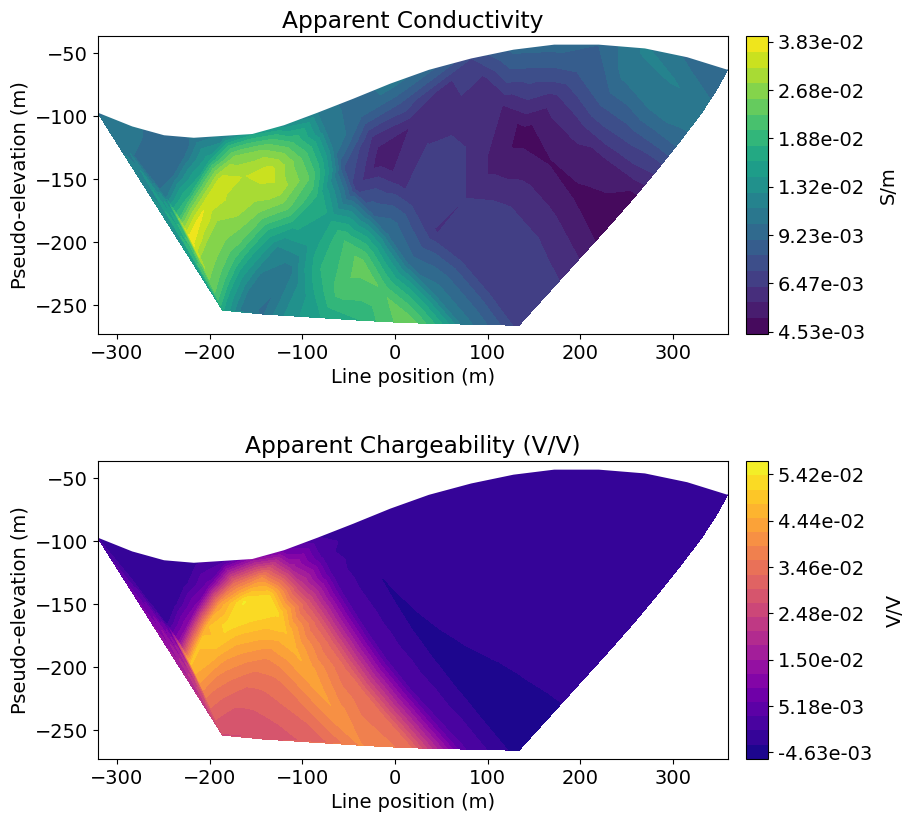

In [24]:
fig = plt.figure(figsize=(9, 8.5))

# Get apparent conductivities from volts and survey geometry
apparent_conductivities = (
    1 / static_utils.apparent_resistivity_from_voltage(dc_survey, dpred_dc)
)

# Plot apparent conductivity
ax1 = fig.add_axes([0.1, 0.58, 0.7, 0.35])
cax1 = fig.add_axes([0.82, 0.58, 0.025, 0.35])
static_utils.plot_pseudosection(
    dc_survey,
    apparent_conductivities,
    "contourf",
    ax=ax1,
    cax=cax1,
    scale="log",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.viridis},
)
ax1.set_title("Apparent Conductivity")

# Plot apparent chargeability

ax2 = fig.add_axes([0.1, 0.08, 0.7, 0.35])
cax2 = fig.add_axes([0.82, 0.08, 0.025, 0.35])
static_utils.plot_pseudosection(
    ip_survey,
    dpred_ip,
    "contourf",
    ax=ax2,
    cax=cax2,
    scale="linear",
    cbar_label="V/V",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.plasma},
)
ax2.set_title("Apparent Chargeability (V/V)")

plt.show()

## Write Outputs (Optional)




In [25]:
if write_output:
    dir_path = os.path.dirname(__file__).split(os.path.sep)
    dir_path.extend(["outputs"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # Write topography
    fname = dir_path + "topo_xyz.txt"
    np.savetxt(fname, topo_xyz, fmt="%.4e")

    # Add 5% Gaussian noise to each DC datum
    np.random.seed(225)
    std = 0.05 * np.abs(dpred_dc)
    dc_noise = std * np.random.rand(len(dpred_dc))
    dobs = dpred_dc + dc_noise

    # Create a survey with the original electrode locations
    # and not the shifted ones
    # Generate source list for DC survey line
    source_list = generate_dcip_sources_line(
        survey_type,
        dc_data_type,
        dimension_type,
        end_locations,
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )
    dc_survey_original = dc.survey.Survey(source_list)

    # Write out data at their original electrode locations (not shifted)
    data_obj = data.Data(dc_survey_original, dobs=dobs, standard_deviation=std)
    fname = dir_path + "dc_data.obs"
    write_dcip2d_ubc(fname, data_obj, "volt", "dobs")

    # Add Gaussian noise equal to 5e-3 V/V
    std = 5e-3 * np.ones_like(dpred_ip)
    ip_noise = std * np.random.rand(len(dpred_ip))
    dobs = dpred_ip + ip_noise

    # Create a survey with the original electrode locations
    # and not the shifted ones
    # Generate source list for DC survey line
    source_list = generate_dcip_sources_line(
        survey_type,
        ip_data_type,
        dimension_type,
        end_locations,
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )
    ip_survey_original = dc.survey.Survey(source_list)

    # Write out data at their original electrode locations (not shifted)
    data_obj = data.Data(ip_survey_original, dobs=dobs, standard_deviation=std)
    fname = dir_path + "ip_data.obs"
    write_dcip2d_ubc(fname, data_obj, "apparent_chargeability", "dobs")